In [1]:
import torch as th
import numpy as np
from torch import nn, optim, functional
from torchvision import datasets, transforms

def train_mnist(model, epochs=5, test_every_ep=90, learning_rate=0.003):

    # This makes our data easier to work with for the Network
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Download/Load Data from Online Hub
    trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
    trainloader = th.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

    # Same for Testing Data
    testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
    testloader = th.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
    test_iter = iter(testloader)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Train the model
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        step = 0   
        for images, labels in trainloader:
            # Flatten the images
            step+=1
            labels = th.nn.functional.one_hot(labels, num_classes=10).float()
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            if step % 30 == 0:
                print('Loss:', loss.item())
            running_loss += loss.item()
            if step % test_every_ep == 0:
                model.eval()
                with th.no_grad(): # Lets Perform a Check to see how Accurate our model is
                    image, labels = next(test_iter) # Get next Training Set
                    labels_one_hot = th.nn.functional.one_hot(labels, num_classes=10).float() # Get MNIST labels for the Training Set
                    output = model(image) # Perform Forward Pass
                    loss = criterion(output, labels_one_hot) # Grade the Output
                    predictions = th.argmax(output, dim=1) # Check to see what it predicted
                    correct = (predictions == labels).sum().item() # See how many it got right
                    total = labels.size(0) 
                print("Accuracy: {:.2f}%".format(correct/total*100))
                print('Testing Loss:', loss.item())
        print(f"Epoch {epoch+1} - Training loss: {running_loss/len(trainloader)}")
    print("Training completed")


c:\Users\John\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CoderSchoolAI v0.0.9: 
CoderSchoolAI: A Python Module designed for teaching Modern Day AI to Kids.

This package includes a range of educational tools and templates designed to simplify complex concepts and offer improved learning opportunities. 
It enables the exploration of foundational principles of problem-solving through Artificial Intelligence, providing structured guidance for the exploration and 
implementation of theoretical concepts.

Key Features:
 - Learning Curriculum: Our module makes learning programming engaging and fun, turning complex ideas into digestible chunks.
 
 - Educational Tools and Templates: We provide tools and templates to simplify complex concepts and enhance learning opportunities.
 
 - Exploration of Foundational Concepts: Our module enables the exploration of foundational principles of problem-solving through Artificial Intelligence.
 - Structural Guidance: We offer structured guidance for exploring and implementing theoretical concepts in a hands-on w

c:\Users\John\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-13 13:16:19,449 - INFO - Using device: cuda


Compiling Network...
Comiled Block:  CoderSchoolAI.Neural.Blocks.InputBlock.InputBlock>,

Comiled Block:  CoderSchoolAI.Neural.Blocks.ConvBlock.ConvBlock>,
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): ReLU()
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)

Comiled Block:  CoderSchoolAI.Neural.Blocks.OutputBlock.OutputBlock>,
  (0): Linear(in_features=3136, out_features=10, bias=True)
  (1): Identity()

cuda


2024-07-13 13:16:50,141 - INFO - Epoch 1/5, Loss: 0.1496, Accuracy: 0.9867
2024-07-13 13:17:22,379 - INFO - Epoch 2/5, Loss: 0.0445, Accuracy: 0.9890
2024-07-13 13:17:54,838 - INFO - Epoch 3/5, Loss: 0.0315, Accuracy: 0.9874
2024-07-13 13:18:26,452 - INFO - Epoch 4/5, Loss: 0.0243, Accuracy: 0.9890
2024-07-13 13:18:59,135 - INFO - Epoch 5/5, Loss: 0.0201, Accuracy: 0.9906
2024-07-13 13:18:59,136 - INFO - Training completed
2024-07-13 13:19:00,147 - INFO - Training progress plot saved as 'training_progress.png'


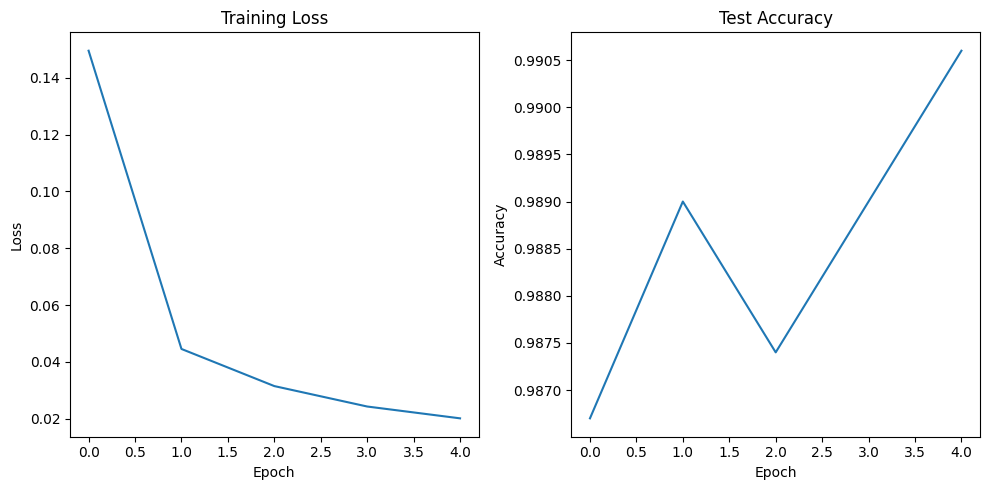

In [1]:
from CoderSchoolAI.Environments.CoderSchoolEnvironments.SnakeEnvironment import *
from CoderSchoolAI.Environments.Attributes import *
from CoderSchoolAI.Neural.Blocks import *
from CoderSchoolAI.Neural.Net import *
from CoderSchoolAI.Training.Datasets import train_on_dataset, MNISTDataset

device = "cuda"

image = ObsAttribute(name="img", space=BoxType(-1, 1, shape=(1, 28, 28)))
input_block = InputBlock(in_attribute=image, device=device)

# Define the ConvBlock which acts as a convolutional layer for processing the game state.
# The depth of 3 represents the number of convolutional layers in this block.
conv_block = ConvBlock(input_shape=input_block.in_attribute.space.shape, num_channels=1, depth=4, device=device)
# Define the OutputBlock that will decide the next action to take based on the current game state.
# The num_classes corresponds to the number of possible actions the snake can take (up, down, left, right).
out_block = OutputBlock(input_size=conv_block.output_size, num_classes=10, device=device)

# Initialize the network and add the blocks
net = Net(device='cuda')

for block in (input_block, conv_block, out_block):
    net.add_block(block)

net.compile()

# Call the function to train the model
mnist_dataset = MNISTDataset()
train_on_dataset(net, mnist_dataset, epochs=5)